In [68]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [69]:
# Required Library
!pip install seqeval==0.0.12

In [70]:
# Importing required Libraries
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import json
import random
import logging
import re
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import transformers
# Correct import statement for pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [71]:
data_file_address = "/kaggle/input/resume-enitity-ner/Resume.json"

In [72]:
# Reading data
df_data = pd.read_json(data_file_address, lines=True)
df_data.head(10)

,content,annotation
0,Govardhana K\nSenior Software Engineer\n\nBeng...,"[{'label': ['Companies worked at'], 'points': ..."
1,"Harini Komaravelli\nTest Analyst at Oracle, Hy...","[{'label': ['Companies worked at'], 'points': ..."
2,Hartej Kathuria\nData Analyst Intern - Oracle ...,"[{'label': ['Skills'], 'points': [{'start': 22..."
3,Ijas Nizamuddin\nAssociate Consultant - State ...,"[{'label': ['Skills'], 'points': [{'start': 46..."
4,"Imgeeyaul Ansari\njava developer\n\nPune, Maha...","[{'label': ['Skills'], 'points': [{'start': 18..."
5,"Jay Madhavi\nNavi Mumbai, Maharashtra - Email ...","[{'label': ['Graduation Year'], 'points': [{'s..."
6,Jitendra Babu\nFI/CO Consultant in Tech Mahind...,"[{'label': ['Graduation Year'], 'points': [{'s..."
7,Jyotirbindu Patnaik\nAssociate consultant@SAP ...,"[{'label': ['Skills'], 'points': [{'start': 30..."
8,Karthihayini C\nSystems Engineer - Infosys Lim...,"[{'label': ['Skills'], 'points': [{'start': 21..."
9,Karthik GV\nArchitect - Microsoft India\n\nHyd...,"[{'label': ['Skills'], 'points': [{'start': 40..."


In [73]:
# Removing New Line characters
for i in range(len(df_data)):
    df_data["content"][i] = df_data["content"][i].replace("\n", " ")
df_data.head()

,content,annotation
0,Govardhana K Senior Software Engineer Bengalu...,"[{'label': ['Companies worked at'], 'points': ..."
1,"Harini Komaravelli Test Analyst at Oracle, Hyd...","[{'label': ['Companies worked at'], 'points': ..."
2,Hartej Kathuria Data Analyst Intern - Oracle R...,"[{'label': ['Skills'], 'points': [{'start': 22..."
3,Ijas Nizamuddin Associate Consultant - State S...,"[{'label': ['Skills'], 'points': [{'start': 46..."
4,"Imgeeyaul Ansari java developer Pune, Maharas...","[{'label': ['Skills'], 'points': [{'start': 18..."


In [74]:
# JSON formatting functions
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data        

In [75]:
data = trim_entity_spans(convert_dataturks_to_spacy(data_file_address))
data[0]

['Govardhana K Senior Software Engineer  Bengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/ b2de315d95905b68  Total IT experience 5 Years 6 Months Cloud Lending Solutions INC 4 Month • Salesforce Developer Oracle 5 Years 2 Month • Core Java Developer Languages Core Java, Go Lang Oracle PL-SQL programming, Sales Force Developer with APEX.  Designations & Promotions  Willing to relocate: Anywhere  WORK EXPERIENCE  Senior Software Engineer  Cloud Lending Solutions -  Bangalore, Karnataka -  January 2018 to Present  Present  Senior Consultant  Oracle -  Bangalore, Karnataka -  November 2016 to December 2017  Staff Consultant  Oracle -  Bangalore, Karnataka -  January 2014 to October 2016  Associate Consultant  Oracle -  Bangalore, Karnataka -  November 2012 to December 2013  EDUCATION  B.E in Computer Science Engineering  Adithya Institute of Technology -  Tamil Nadu  September 2008 to June 2012  https://www.indeed.com/r/Govardhana-K/b2de315d95905b68?isid=rex-

In [76]:
# Changing data to appropriate format so as to feed it to the model
from tqdm import tqdm_notebook as tqdm
cleanedDF = pd.DataFrame(columns=["setences_cleaned"])
sum1 = 0
for i in tqdm(range(len(data))):
    start = 0
    emptyList = ["Empty"] * len(data[i][0].split())
    numberOfWords = 0
    lenOfString = len(data[i][0])
    strData = data[i][0]
    strDictData = data[i][1]
    lastIndexOfSpace = strData.rfind(' ')
    for i in range(lenOfString):
        if (strData[i]==" " and strData[i+1]!=" "):
            for k,v in strDictData.items():
                for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (start>=int(entList[0]) and i<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        break
                    else:
                        continue
            start = i + 1  
            numberOfWords += 1
        if (i == lastIndexOfSpace):
            for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (lastIndexOfSpace>=int(entList[0]) and lenOfString<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        numberOfWords += 1
    cleanedDF = cleanedDF.append(pd.Series([emptyList],  index=cleanedDF.columns ), ignore_index=True )
    sum1 = sum1 + numberOfWords

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [77]:
cleanedDF.head()

,setences_cleaned
0,"[Name, Name, Designation, Designation, Empty, ..."
1,"[Name, Name, Designation, Designation, Empty, ..."
2,"[Name, Name, Designation, Designation, Designa..."
3,"[Name, Name, Designation, Designation, Empty, ..."
4,"[Name, Name, Designation, Empty, Empty, Empty,..."


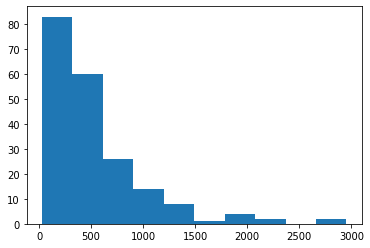

In [78]:
import matplotlib.pyplot as plt
totalNumWords = [len(one_comment.split()) for one_comment in df_data["content"]]
plt.hist(totalNumWords)
plt.show()

In [79]:
MAX_LEN = 512
bs = 16

In [80]:
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

In [81]:
from transformers import AutoTokenizer, BertForTokenClassification
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [82]:
# Tokenize the texts to get token IDs
tokenized_texts = [tokenizer.encode(sent) for sent in df_data["content"]]

In [83]:
# Pad the sequences
input_ids = pad_sequences(tokenized_texts, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [84]:
#input_ids = pad_sequences(tokenized_texts,
                      #    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
#MAX_LEN=512   
#input_ids = pad_sequences(tokenized_texts, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

#print(input_ids[0])

In [85]:
tags_vals = ["UNKNOWN", "Name", "Degree","Skills","College Name","Email Address","Designation","Companies worked at","Empty","Graduation Year","Years of Experience","Location"]
tag2idx = {t: i for i, t in enumerate(tags_vals)}
idx2tag = {i: t for t, i in tag2idx.items()}

In [86]:
labels = cleanedDF["setences_cleaned"].tolist()

In [87]:
print(set(labels[61]))

{'College Name', 'Empty', 'Skills', 'Years of Experience', 'Graduation Year', 'Designation', 'Name', 'Companies worked at'}


In [88]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["Empty"], padding="post",
                     dtype="long", truncating="post")

In [89]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [90]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [91]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [92]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [93]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

In [94]:
model.cuda();

In [95]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [96]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [97]:
epochs = 30
max_grad_norm = 1.0
# Training loop
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
            tmp_eval_loss = outputs[0]
            logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        #print('predictions',predictions)
        #print('true_labels',true_labels)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    
    pred_tags=[]
    for prediction in predictions:
        sentence_tags = []  # Initialize a list to store predicted labels for a single sentence
        for predicted_index in prediction:
            if predicted_index < len(tags_vals):
                label = tags_vals[predicted_index]
                sentence_tags.append(label)  # Append the label to the sentence_tags list
        pred_tags.append(sentence_tags)
    
    #pred_tags = [tag2idx[p_i] for p in predictions for p_i in p]
    
    #valid_tags = [tag2idx[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
     # Convert predictions and true labels to tag names
    #pred_tags = [idx2tag[p_i] for p in predictions for p_i in p]
    #print('pred_tags',pred_tags)
    #valid_tags = [idx2tag[l_ii] for l in true_labels for l_ii in l]
    
    # Initialize valid_tags list to store valid tags
    valid_tags = []

# Loop through each array in true_labels
    for arr in true_labels:
        for row in arr:
            for label_index in row:
                if label_index < len(tags_vals):
                    label = tags_vals[label_index]
                valid_tags.append(label)  # Append the label to the valid_tags list
    #print(f"Valid Tags: {valid_tags}")
    
    # Assuming pred_tags and valid_tags are lists of lists
    pred_tags_flat = [tag for tags in pred_tags for tag in tags]
    valid_tags_flat = [tag for tags in valid_tags for tag in tags]

    # Calculate F1-score
    f1 = f1_score([valid_tags_flat], [pred_tags_flat])
    print("F1-Score: {:.2f}".format(f1 * 100))
    #print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
torch.save(model.state_dict(), "/kaggle/working/final_model.pt")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.8731963088115057
Validation loss: 0.4495006948709488
Validation Accuracy: 0.934814453125


Epoch:   3%|▎         | 1/30 [00:10<04:54, 10.17s/it]

F1-Score: 0.00
Train loss: 0.4638449524839719
Validation loss: 0.40767909586429596
Validation Accuracy: 0.934814453125


Epoch:   7%|▋         | 2/30 [00:20<04:44, 10.16s/it]

F1-Score: 0.00
Train loss: 0.45008134593566257
Validation loss: 0.4038243293762207
Validation Accuracy: 0.934814453125


Epoch:  10%|█         | 3/30 [00:30<04:33, 10.14s/it]

F1-Score: 0.00
Train loss: 0.41838566586375237


Epoch:  13%|█▎        | 4/30 [00:40<04:23, 10.13s/it]

Validation loss: 0.393087700009346
Validation Accuracy: 0.934814453125
F1-Score: 0.00
Train loss: 0.42063256601492566


Epoch:  17%|█▋        | 5/30 [00:50<04:13, 10.12s/it]

Validation loss: 0.3817390501499176
Validation Accuracy: 0.934814453125
F1-Score: 0.00
Train loss: 0.3938327108820279


Epoch:  20%|██        | 6/30 [01:00<04:03, 10.13s/it]

Validation loss: 0.403491273522377
Validation Accuracy: 0.934814453125
F1-Score: 0.00
Train loss: 0.4217228467265765


Epoch:  23%|██▎       | 7/30 [01:10<03:52, 10.12s/it]

Validation loss: 0.37447813153266907
Validation Accuracy: 0.93499755859375
F1-Score: 0.00
Train loss: 0.3844195380806923


Epoch:  27%|██▋       | 8/30 [01:20<03:42, 10.12s/it]

Validation loss: 0.36570683121681213
Validation Accuracy: 0.9356689453125
F1-Score: 0.00
Train loss: 0.3566925525665283


Epoch:  30%|███       | 9/30 [01:31<03:32, 10.12s/it]

Validation loss: 0.3766434043645859
Validation Accuracy: 0.92864990234375
F1-Score: 0.00
Train loss: 0.3251875427862008
Validation loss: 0.4247446060180664
Validation Accuracy: 0.8756103515625


Epoch:  33%|███▎      | 10/30 [01:41<03:22, 10.12s/it]

F1-Score: 0.00
Train loss: 0.2864701561629772


Epoch:  37%|███▋      | 11/30 [01:51<03:12, 10.13s/it]

Validation loss: 0.36759383976459503
Validation Accuracy: 0.93157958984375
F1-Score: 0.00
Train loss: 0.27064185092846554


Epoch:  40%|████      | 12/30 [02:01<03:02, 10.13s/it]

Validation loss: 0.37364891171455383
Validation Accuracy: 0.90521240234375
F1-Score: 0.00
Train loss: 0.26842696592211723
Validation loss: 0.3830002546310425
Validation Accuracy: 0.93402099609375


Epoch:  43%|████▎     | 13/30 [02:11<02:52, 10.13s/it]

F1-Score: 0.00
Train loss: 0.2574421713749568


Epoch:  47%|████▋     | 14/30 [02:21<02:42, 10.13s/it]

Validation loss: 0.3449111729860306
Validation Accuracy: 0.92535400390625
F1-Score: 0.00
Train loss: 0.23990345746278763


Epoch:  50%|█████     | 15/30 [02:31<02:31, 10.12s/it]

Validation loss: 0.36346183717250824
Validation Accuracy: 0.9334716796875
F1-Score: 0.00
Train loss: 0.2211559178928534


Epoch:  53%|█████▎    | 16/30 [02:41<02:21, 10.12s/it]

Validation loss: 0.3824708014726639
Validation Accuracy: 0.9285888671875
F1-Score: 0.00
Train loss: 0.21721354375282922


Epoch:  57%|█████▋    | 17/30 [02:52<02:11, 10.12s/it]

Validation loss: 0.3450380563735962
Validation Accuracy: 0.9384765625
F1-Score: 0.00
Train loss: 0.19392011873424053


Epoch:  60%|██████    | 18/30 [03:02<02:01, 10.12s/it]

Validation loss: 0.3800334930419922
Validation Accuracy: 0.91864013671875
F1-Score: 0.00
Train loss: 0.18765681609511375


Epoch:  63%|██████▎   | 19/30 [03:12<01:51, 10.13s/it]

Validation loss: 0.3707120418548584
Validation Accuracy: 0.92987060546875
F1-Score: 0.00
Train loss: 0.19434713448087373


Epoch:  67%|██████▋   | 20/30 [03:22<01:41, 10.13s/it]

Validation loss: 0.3768000900745392
Validation Accuracy: 0.93695068359375
F1-Score: 0.00
Train loss: 0.17660013462106386
Validation loss: 0.4119969457387924
Validation Accuracy: 0.91650390625


Epoch:  70%|███████   | 21/30 [03:32<01:31, 10.12s/it]

F1-Score: 0.00
Train loss: 0.16478772026797137


Epoch:  73%|███████▎  | 22/30 [03:42<01:20, 10.12s/it]

Validation loss: 0.3800031542778015
Validation Accuracy: 0.931884765625
F1-Score: 0.00
Train loss: 0.16109190322458744
Validation loss: 0.4118543416261673
Validation Accuracy: 0.919677734375


Epoch:  77%|███████▋  | 23/30 [03:52<01:10, 10.12s/it]

F1-Score: 0.00
Train loss: 0.15584062536557516


Epoch:  80%|████████  | 24/30 [04:02<01:00, 10.12s/it]

Validation loss: 0.40064649283885956
Validation Accuracy: 0.93280029296875
F1-Score: 0.00
Train loss: 0.1491913435359796


Epoch:  83%|████████▎ | 25/30 [04:13<00:50, 10.12s/it]

Validation loss: 0.41469940543174744
Validation Accuracy: 0.9295654296875
F1-Score: 0.00
Train loss: 0.13801170202593008
Validation loss: 0.3783005475997925
Validation Accuracy: 0.94140625


Epoch:  87%|████████▋ | 26/30 [04:23<00:40, 10.12s/it]

F1-Score: 0.00
Train loss: 0.1355921421200037
Validation loss: 0.3938888907432556
Validation Accuracy: 0.92266845703125


Epoch:  90%|█████████ | 27/30 [04:33<00:30, 10.12s/it]

F1-Score: 0.00
Train loss: 0.13076498545706272


Epoch:  93%|█████████▎| 28/30 [04:43<00:20, 10.12s/it]

Validation loss: 0.38340671360492706
Validation Accuracy: 0.93603515625
F1-Score: 0.00
Train loss: 0.12691623841722807
Validation loss: 0.42846544086933136
Validation Accuracy: 0.91943359375


Epoch:  97%|█████████▋| 29/30 [04:53<00:10, 10.12s/it]

F1-Score: 0.00
Train loss: 0.11972163245081902


Epoch: 100%|██████████| 30/30 [05:03<00:00, 10.12s/it]

Validation loss: 0.42636117339134216
Validation Accuracy: 0.92547607421875
F1-Score: 0.00


In [98]:
# Example test sentence
test_sentence = """Sharan

AI / Machine Learning

Delhi, India Email me on Indeed
•
20+ years of experience in data handling, design, and development
•
Data Warehouse: Data analysis, star/snow flake scema data modelling and design specific to
data warehousing and business intelligence
•
Database: Experience in database designing, scalability, back-up and recovery, writing and
optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes.
Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure,
Stream Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake
analytics(U-SQL)
Willing to relocate anywhere

WORK EXPERIENCE
Software Engineer
Microsoft – Bangalore, Karnataka
January 2000 to Present
1. Microsoft Rewards Live dashboards:
Description: - Microsoft rewards is loyalty program that rewards Users for browsing and shopping
online. Microsoft Rewards members can earn points when searching with Bing, browsing with
Microsoft Edge and making purchases at the Xbox Store, the Windows Store and the Microsoft
Store. Plus, user can pick up bonus points for taking daily quizzes and tours on the Microsoft
rewards website. Rewards live dashboards gives a live picture of usage world-wide and by
markets like US, Canada, Australia, new user registration count, top/bottom performing rewards
offers, orders stats and weekly trends of user activities, orders and new user registrations. the
PBI tiles gets refreshed in different frequencies starting from 5 seconds to 30 minutes.
Technology/Tools used

EDUCATION
Indian Institute of Technology – Mumbai
2001

SKILLS
Machine Learning, Natural Language Processing, and Big Data Handling

ADDITIONAL INFORMATION
Professional Skills
• Excellent analytical, problem solving, communication, knowledge transfer and interpersonal
skills with ability to interact with individuals at all the levels
• Quick learner and maintains cordial relationship with project manager and team members and
good performer both in team and independent job environments
• Positive attitude towards superiors &amp; peers
• Supervised junior developers throughout project lifecycle and provided technical assistance """


In [99]:
# Tokenize input
tokenized_input = tokenizer.encode(test_sentence, add_special_tokens=True, return_tensors='pt')

# Ensure the model runs on the same device as training (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
tokenized_input = tokenized_input.to(device)

# Set model to evaluation mode
model.eval()

# Forward pass
with torch.no_grad():
    outputs = model(tokenized_input)
    logits = outputs[0]  # Logits are the output predictions before applying activation function

# Move logits to CPU and convert to numpy array
logits = logits.detach().cpu().numpy()

# Get predictions
predictions = np.argmax(logits, axis=2)[0]  # Assuming batch size 1

# Convert predictions to tag labels
predicted_tags = [tags_vals[prediction] for prediction in predictions]

# Print predicted tags for each token
print("Predicted Tags:")
for token, tag in zip(tokenizer.tokenize(test_sentence), predicted_tags):
    print(f"{token}\t{tag}")


Predicted Tags:
sha	Name
##ran	Name
ai	Empty
/	Empty
machine	Empty
learning	Empty
delhi	Empty
,	Empty
india	Empty
email	Empty
me	Empty
on	Empty
indeed	Empty
•	Empty
20	Empty
+	Empty
years	Empty
of	Empty
experience	Empty
in	Empty
data	Empty
handling	Empty
,	Empty
design	Empty
,	Empty
and	Empty
development	Empty
•	Empty
data	Empty
warehouse	Empty
:	Empty
data	Empty
analysis	Empty
,	Empty
star	Empty
/	Empty
snow	Empty
fl	Empty
##ake	Empty
sc	Empty
##ema	Empty
data	Empty
modelling	Empty
and	Empty
design	Empty
specific	Empty
to	Empty
data	Empty
ware	Empty
##ho	Empty
##using	Empty
and	Empty
business	Empty
intelligence	Empty
•	Empty
database	Empty
:	Empty
experience	Empty
in	Empty
database	Empty
designing	Empty
,	Empty
scala	Empty
##bility	Empty
,	Empty
back	Empty
-	Empty
up	Empty
and	Empty
recovery	Empty
,	Empty
writing	Empty
and	Empty
opt	Empty
##imi	Empty
##zing	Empty
sql	Empty
code	Empty
and	Empty
stored	Empty
procedures	Empty
,	Empty
creating	Empty
functions	Empty
,	Empty
views	Empty
,	E